In [1]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

Loading the data and encoding the "from" and "to" columns so that it is in the right format for the graph structure.

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv("omnipath.csv")

data = data.iloc[:, [1, 2, 3]]

node_encoder = LabelEncoder()

nodes = pd.concat([data['from'], data['to']]).unique()
node_encoder.fit(nodes)

data['from_encoded'] = node_encoder.transform(data['from'])
data['to_encoded'] = node_encoder.transform(data['to'])

In [6]:
data

,from,to,sign,from_encoded,to_encoded
0,A2M,KLK3,-1,2,4572
1,A2M,LRP1,1,2,4814
2,A2M,MMP2,-1,2,5225
3,A2M,MMP9,-1,2,5234
4,AAAS:AHCTF1:GLE1:NDC1:NUP107:NUP133:NUP153:NUP...,XPOT,1,5,9653
...,...,...,...,...,...
125427,ZXDC,CDKN2A,1,9895,1446
125428,ZXDC,CIITA,1,9895,1621
125429,ZXDC,HLA-E,1,9895,3810
125430,ZXDC,IL5,1,9895,4180


Using the PyTorch Geometric package to set up the Graph Autoencoder.

In the below code, we need to stucture the data into a PyG data object for futher processing.

Since we dont have node features in the dataset, we are randomly initializing it with a set node feature dimention (ex: 32, 64, 128). The values are random at first but they will get updated during training to learn the graph data.


Note: Experimted with 64, 128 as well to see which gave better performance.

In [107]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [108]:
data_py

Data(x=[9898, 32], edge_index=[2, 125432], edge_attr=[125432, 1])

As we can see, we have 9898 unique nodes with 125432 links.

In [109]:
data_py = train_test_split_edges(data_py)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [110]:
data_py

Data(x=[9898, 32], val_pos_edge_index=[2, 2183], val_pos_edge_attr=[2183, 1], test_pos_edge_index=[2, 4366], test_pos_edge_attr=[4366, 1], train_pos_edge_index=[2, 74224], train_pos_edge_attr=[74224, 1], train_neg_adj_mask=[9898, 9898], val_neg_edge_index=[2, 2183], test_neg_edge_index=[2, 4366])

We split the graph into train, test and validation.

We see train_pos_edge_index which are the links that exist in the graph and train_neg_edge are links that do not exist in the graph. This will help the model accordingly learn relavent edges.

We start off by creating a Graph Convolutional Network (GCN) Encoder. We will begin the expirment by using two GCN layers.

the in_channels is the number of node features. The out_channels is the the dimension of the latent space.(output dimension of the encoder)

These embeddings are then used by the decoder to reconstruct the graph structure.

In [11]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


In [12]:
from torch_geometric.nn import GAE

We dont need to explicitly add the decoder part as The GAE class implicitly uses a simple inner product decoder by default.

In [13]:
# parameters
out_channels = 2
num_features = data_py.x.shape[1]
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# To GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

out_channel, num_features and learning rate are some parameters that we will tune to see which gives better performance.

In [14]:
model

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(32, 4)
    (conv2): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)

To view the output of the parameters and encoding before training:



In [ ]:
print("Initial Parameters:", list(model.parameters())[0].clone())


Initial Parameters: tensor([0., 0., 0., 0.], grad_fn=<CloneBackward0>)


In [ ]:
model.encode(x, train_pos_edge_index)

tensor([[ 0.4183, -0.1657],
        [ 0.3938, -0.1260],
        [ 0.1513, -0.0484],
        ...,
        [ 0.6389, -0.2045],
        [ 0.1977, -0.0633],
        [ 0.5501, -0.1844]], grad_fn=<AddBackward0>)

We now setup the train, test and validation functions:

In [15]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()

    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)


def val(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [16]:
def test(model_best,pos_edge_index, neg_edge_index):
    model_best.eval()
    with torch.no_grad():
        z = model_best.encode(x, train_pos_edge_index)
        pos_prob = model_best.decode(z, pos_edge_index)
        neg_prob = model_best.decode(z, neg_edge_index)

    return pos_prob, neg_prob

For the above test function, we output the probabilities of whether a link exists or not.

In [17]:
import copy

best_val_auc = 0
best_model = None

a = [] #train loss
b = [] #val_auc
c = [] #val_ap
d = [] #val loss

for epoch in range(1, epochs + 1):
    loss, loss2 = train()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 001, Loss: 1.3738, Val AUC: 0.8460, Val AP: 0.8294
Epoch: 002, Loss: 1.3329, Val AUC: 0.8653, Val AP: 0.8574
Epoch: 003, Loss: 1.2911, Val AUC: 0.8780, Val AP: 0.8744
Epoch: 004, Loss: 1.2520, Val AUC: 0.8871, Val AP: 0.8861
Epoch: 005, Loss: 1.2291, Val AUC: 0.8878, Val AP: 0.8876
Epoch: 006, Loss: 1.2256, Val AUC: 0.8883, Val AP: 0.8879
Epoch: 007, Loss: 1.2328, Val AUC: 0.8848, Val AP: 0.8832
Epoch: 008, Loss: 1.2336, Val AUC: 0.8783, Val AP: 0.8746
Epoch: 009, Loss: 1.2270, Val AUC: 0.8783, Val AP: 0.8742
Epoch: 010, Loss: 1.2190, Val AUC: 0.8840, Val AP: 0.8823
Epoch: 011, Loss: 1.2080, Val AUC: 0.8861, Val AP: 0.8848
Epoch: 012, Loss: 1.2061, Val AUC: 0.8942, Val AP: 0.8952
Epoch: 013, Loss: 1.2010, Val AUC: 0.8975, Val AP: 0.8995
Epoch: 014, Loss: 1.1994, Val AUC: 0.8938, Val AP: 0.8947
Epoch: 015, Loss: 1.1958, Val AUC: 0.8902, Val AP: 0.8905
Epoch: 016, Loss: 1.1958, Val AUC: 0.8915, Val AP: 0.8924
Epoch: 017, Loss: 1.1915, Val AUC: 0.8962, Val AP: 0.8985
Epoch: 018, Lo

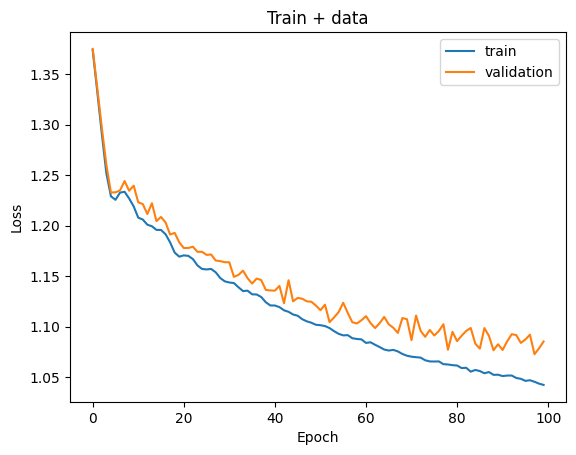

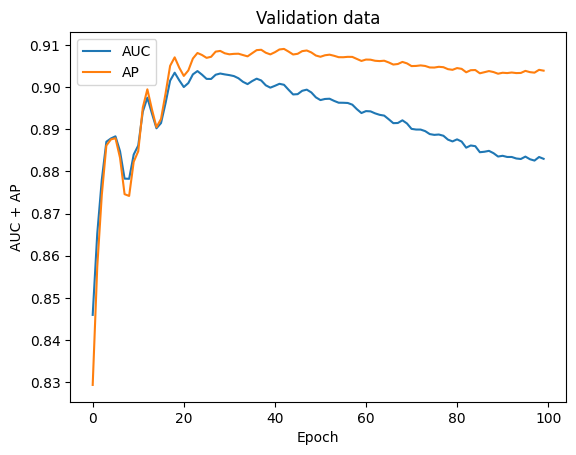

In [18]:
import matplotlib.pyplot as plt


plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

Based on the above plot, it seems like we should increase the number of epoch. We shall do that in the following experiments.

To view the output of the parameters and encoding after training:

In [ ]:
print("Initial Parameters:", list(model.parameters())[0].clone())


Initial Parameters: tensor([-0.1105, -0.0056, -0.1107,  0.0704], grad_fn=<CloneBackward0>)


In [ ]:
model.encode(x, train_pos_edge_index)

tensor([[ 0.4311, -0.4261],
        [ 0.5443, -0.5380],
        [ 0.0046, -0.0042],
        ...,
        [ 1.1301, -1.1176],
        [-0.0576,  0.0568],
        [-0.5152,  0.5053]], grad_fn=<AddBackward0>)

In [ ]:
model_base = best_model
pos, neg = test(model_base,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

The total number of test_pos_edge_index = 4366

The total number of test_neg_edge_index = 4366

Expirement-1:

**2 layer GCN with 32 node features, 2 latent space dimension, 100 epoch, 0.01 learning rate.**


In [ ]:
percentage = ((pos >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

62.14% links predicted correctly


The above is the base model configuration, we shall now experiment with different hyperparameter values below to improve the performance

Expirement-2:

**4 layer GCN with 32 node features, 16 latent space dimension, 500 epoch, 0.01 learning rate.**


In [ ]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

data_py = train_test_split_edges(data_py)

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv4 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        return self.conv4(x, edge_index)

# parameters
out_channels = 16
num_features = data_py.x.shape[1]
epochs = 500

# model
model = GAE(GCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


best_val_auc = 0
best_model = None

a = [] #train loss
b = [] #val_auc
c = [] #val_ap
d = [] #val loss

for epoch in range(1, epochs + 1):
    loss, loss2 = train()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 001, Loss: 1.3462, Val AUC: 0.8891, Val AP: 0.8940
Epoch: 002, Loss: 1.2637, Val AUC: 0.9077, Val AP: 0.9149
Epoch: 003, Loss: 1.2183, Val AUC: 0.9122, Val AP: 0.9198
Epoch: 004, Loss: 1.2037, Val AUC: 0.9140, Val AP: 0.9215
Epoch: 005, Loss: 1.1910, Val AUC: 0.9170, Val AP: 0.9242
Epoch: 006, Loss: 1.1944, Val AUC: 0.9196, Val AP: 0.9266
Epoch: 007, Loss: 1.1766, Val AUC: 0.9183, Val AP: 0.9254
Epoch: 008, Loss: 1.1737, Val AUC: 0.9189, Val AP: 0.9260
Epoch: 009, Loss: 1.1740, Val AUC: 0.9206, Val AP: 0.9276
Epoch: 010, Loss: 1.1602, Val AUC: 0.9212, Val AP: 0.9280
Epoch: 011, Loss: 1.1557, Val AUC: 0.9219, Val AP: 0.9287
Epoch: 012, Loss: 1.1529, Val AUC: 0.9226, Val AP: 0.9294
Epoch: 013, Loss: 1.1408, Val AUC: 0.9231, Val AP: 0.9299
Epoch: 014, Loss: 1.1339, Val AUC: 0.9235, Val AP: 0.9302
Epoch: 015, Loss: 1.1287, Val AUC: 0.9237, Val AP: 0.9304
Epoch: 016, Loss: 1.1172, Val AUC: 0.9219, Val AP: 0.9300
Epoch: 017, Loss: 1.1109, Val AUC: 0.9253, Val AP: 0.9334
Epoch: 018, Lo

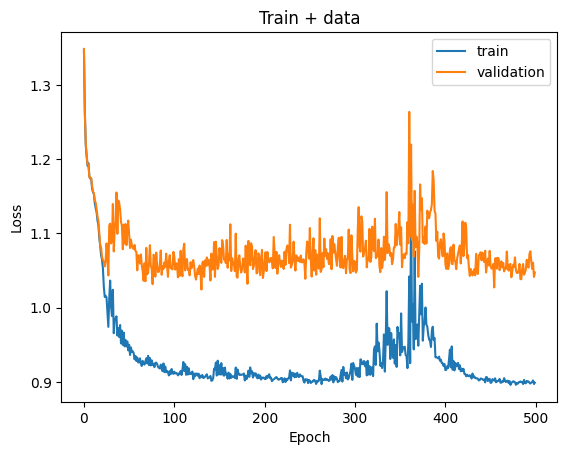

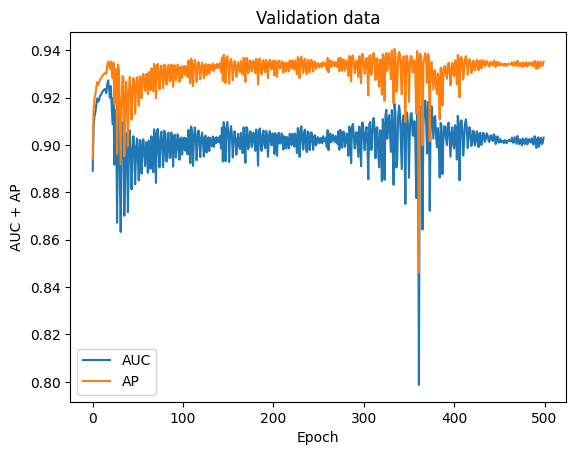

In [ ]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [ ]:
model_2 = best_model
pos_2, neg_2 = test(model_2,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_2 >= 0.6).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

88.66% links predicted correctly


Setting up Bayesian Optimization to find the best paramters for the hyperparameters:

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
import optuna
from tqdm import tqdm


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(GCNEncoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, 2 * out_channels))


        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(2 * out_channels, 2 * out_channels))
        self.convs.append(GCNConv(2 * out_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index).relu()
        return self.convs[-1](x, edge_index)



def objective(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of GCN layers
    out_channels = trial.suggest_int('out_channels', 8, 64) # Latent dimension
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate
    node_feature_dim = trial.suggest_categorical('node_features', [16, 32, 64, 128])  #node feature dimension


    num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1
    node_features = torch.rand((num_nodes, node_feature_dim), dtype=torch.float)

    #PyG Data object
    data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    data_py = train_test_split_edges(data_py)


    # model
    model = GAE(GCNEncoder(node_feature_dim, out_channels,num_layers))


    # move to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data_py.x.to(device)
    train_pos_edge_index = data_py.train_pos_edge_index.to(device)
    val_pos_edge_index = data_py.val_pos_edge_index.to(device)


    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    best_val_auc = 0


    for epoch in tqdm(range(300), desc=f"Trial {trial.number + 1} Progress", leave=False):
        loss, loss2 = train()

        # Evaluate on validation set
        val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)

        # Saving the best model based on validation performance and to prevent overfitting
        if val_auc > best_val_auc:
            best_val_auc = val_auc


    return best_val_auc  # Objective metric to maximize


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_trial.params)


[I 2024-11-02 17:15:58,758] A new study created in memory with name: no-name-2f9dd610-f6f9-4f88-be5c-f20ce181a0f4
<ipython-input-75-b30a23079c93>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)
[I 2024-11-02 17:18:00,882] Trial 0 finished with value: 0.9630249907197351 and parameters: {'num_layers': 2, 'out_channels': 62, 'lr': 0.00017673652275959067, 'node_features': 128}. Best is trial 0 with value: 0.9630249907197351.
<ipython-input-75-b30a23079c93>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

Best hyperparameters: {'num_layers': 5, 'out_channels': 61, 'lr': 0.007212190316513179, 'node_features': 16}


In [19]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  #Unique nodes
node_features = torch.rand((num_nodes, 16), dtype=torch.float)  # Node feature Shape: (num_nodes, 16)

#PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

data_py = train_test_split_edges(data_py)

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv4 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv5 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        return self.conv5(x, edge_index)

# parameters
out_channels = 61
num_features = data_py.x.shape[1]
epochs = 300

# model
model = GAE(GCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.007212190316513179)


best_val_auc = 0
best_model = None

a = [] #train loss
b = [] #val_auc
c = [] #val_ap
d = [] #val loss

for epoch in range(1, epochs + 1):
    loss, loss2 = train()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 001, Loss: 1.2255, Val AUC: 0.9175, Val AP: 0.9182
Epoch: 002, Loss: 4.5441, Val AUC: 0.9005, Val AP: 0.9052
Epoch: 003, Loss: 1.2052, Val AUC: 0.9017, Val AP: 0.9065
Epoch: 004, Loss: 1.3086, Val AUC: 0.8970, Val AP: 0.9017
Epoch: 005, Loss: 1.2124, Val AUC: 0.9007, Val AP: 0.9056
Epoch: 006, Loss: 1.2249, Val AUC: 0.9037, Val AP: 0.9087
Epoch: 007, Loss: 1.2019, Val AUC: 0.9046, Val AP: 0.9098
Epoch: 008, Loss: 1.2279, Val AUC: 0.9052, Val AP: 0.9102
Epoch: 009, Loss: 1.1985, Val AUC: 0.9071, Val AP: 0.9120
Epoch: 010, Loss: 1.2106, Val AUC: 0.9101, Val AP: 0.9150
Epoch: 011, Loss: 1.1976, Val AUC: 0.9102, Val AP: 0.9152
Epoch: 012, Loss: 1.1860, Val AUC: 0.9114, Val AP: 0.9165
Epoch: 013, Loss: 1.1916, Val AUC: 0.9116, Val AP: 0.9164
Epoch: 014, Loss: 1.1762, Val AUC: 0.9143, Val AP: 0.9189
Epoch: 015, Loss: 1.1735, Val AUC: 0.9170, Val AP: 0.9219
Epoch: 016, Loss: 1.1552, Val AUC: 0.9180, Val AP: 0.9229
Epoch: 017, Loss: 1.1516, Val AUC: 0.9197, Val AP: 0.9246
Epoch: 018, Lo

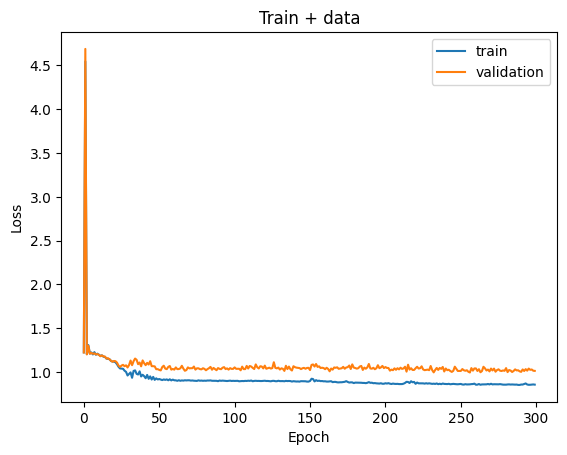

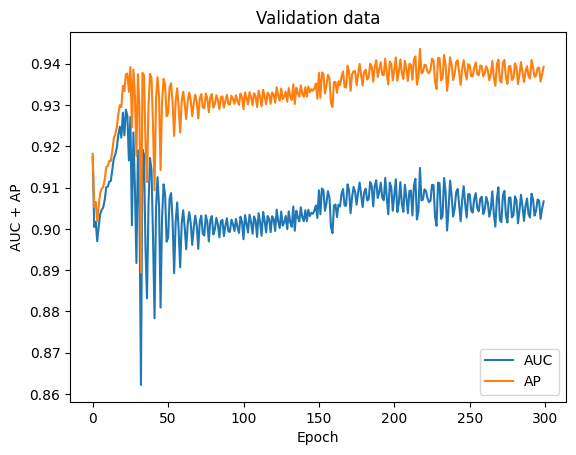

In [20]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [21]:
model_final_gae = best_model
pos_final_gae, neg_final_gae = test(model_final_gae,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [28]:
percentage = ((pos_final_gae >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

75.08% links predicted correctly
